# Computer Vision - P5

### **Carefully read the file `README.md` as well as the following instructions before start coding.**

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Campus Virtual): December 11th, 23:00 h** 

==============================================================================================
## Practicum 5: Image search using textures


==============================================================================================



The exercises of this notebook will show how we can perform image similarity search using:

- Gaussian filters
- Descriptors based on texture and color

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.



 The function should return a feature vector obtained by averaging each filter response on the image.  

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

## Looking at the images

In [64]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io, exposure
import os

import matplotlib.pyplot as plt

In [2]:
path = "./images/texturesimages/buildings/"
building_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

path = "./images/texturesimages/forest/"
forest_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

path = "./images/texturesimages/sunset/"
sunset_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

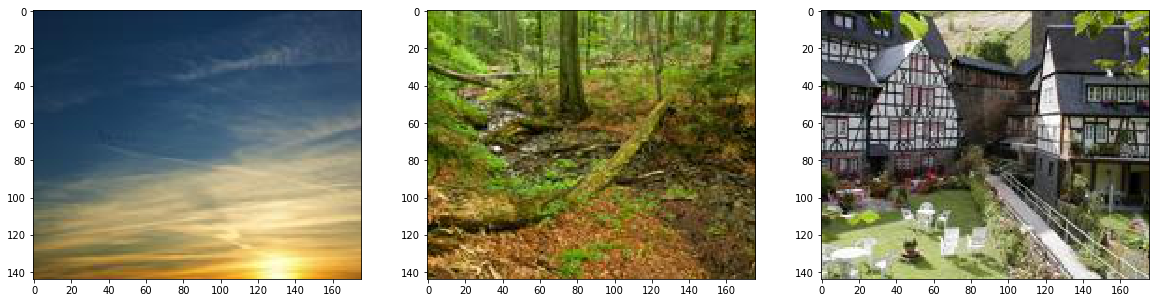

In [3]:
fig, ax= plt.subplots(ncols=3, nrows=1, figsize=(20,30))

ax[0].imshow(sunset_images[0])
ax[1].imshow(forest_images[0])
ax[2].imshow(building_images[0])
plt.show()

In [4]:
len(sunset_images), len(forest_images), len(sunset_images)

(30, 30, 30)

# Filter banks

We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


## Leung-Malik (LM) Filter Bank

In [5]:
import LM_filters

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


In [6]:
filter_bank = LM_filters.makeLMfilters()
filter_bank.shape

(49, 49, 48)

### Plotting all filters

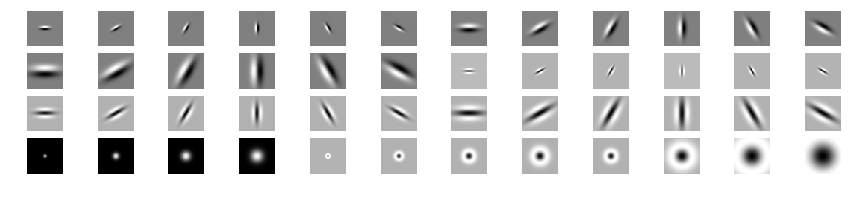

In [7]:
n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1


## Exercise 5.1 Plot the convolved image by some of the filters


Make a function `visualize_features(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png">


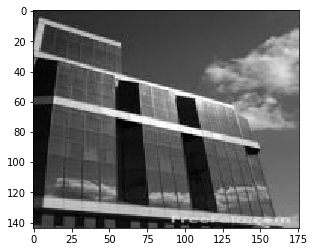

In [8]:
im = building_images[5]
im = skimage.color.rgb2gray(im)
plt.imshow(im, cmap="gray")

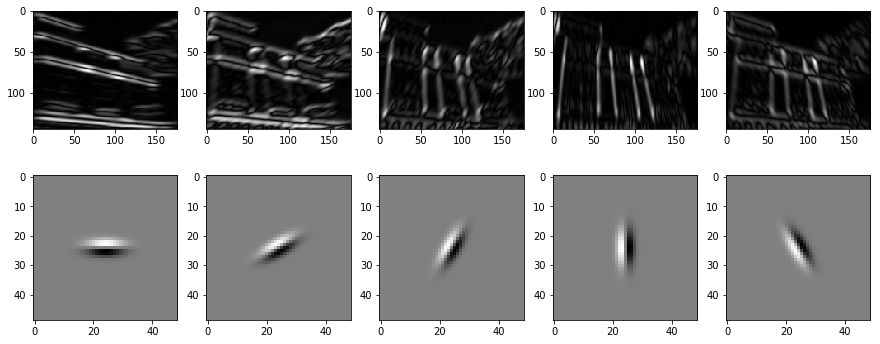

In [9]:
def visualize_features(im,  filter_bank, n_filters=5):
    fig, ax = plt.subplots(ncols=n_filters, nrows=2, figsize=(15,6))
    for i in range(n_filters):
        ax[1,i].imshow(filter_bank[:,:,i], cmap='gray')
        twod_mask = np.abs(scipy.ndimage.convolve(im, filter_bank[:,:,i]))
        ax[0,i].imshow(twod_mask, cmap='gray')
        
visualize_features(im, filter_bank)


## Exercise 5.2 Constructing a feature vector for a given image


Given $D$ filters from the filter bank and a single image `image`, make a function `features_from_filter_bank(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$



In [10]:
im = skimage.color.rgb2gray(building_images[0])

def features_from_filter_bank(image, filter_bank, n_filters):
    ## Complete this function
    im_conv = np.zeros(image.shape)
    features_for_im = np.zeros(n_filters)
    for i in range(n_filters):
        im_conv = scipy.ndimage.convolve(image, filter_bank[:,:,i])
        features_for_im[i] = np.mean(np.abs(im_conv))
  
    return features_for_im

features_for_im = features_from_filter_bank(im, filter_bank, n_filters)


## Exercise 5.3 Constructing the matrix of the feature vectors for all images

Implement a function `get_class_Features(all_images, filter_bank)` that applies `features_from_filter_bank` to get a feature vector for each of the images in the union of the three datasets (forest, buildings, sunset). It must return a matrix containing at row $k$ feature vector for the input image $k$.


Wall time: 7min 49s

In [225]:
all_images = building_images + forest_images + sunset_images

In [12]:
%%time

def get_class_features(all_images,  filter_bank):
    n_images = len(all_images)
    n_filters = filter_bank.shape[-1]
    all_feature_vectors=np.zeros((n_images,filter_bank.shape[-1]))
    for i in range(n_images):
        all_feature_vectors[i] = features_from_filter_bank(skimage.color.rgb2gray(all_images[i]), 
                                                           filter_bank, 
                                                           n_filters)

    return all_feature_vectors

all_feature_vectors=get_class_features(all_images,  filter_bank)

CPU times: user 9min 21s, sys: 9.59 s, total: 9min 30s
Wall time: 9min 34s


## Exercise 5.4 Visualizing the features of an image

Define a function `visualize_features` that given a feature index and an array containing all feature vectors, plots its values for the three datasets using different colors for each dataset (in total plots should contain 3 colors).


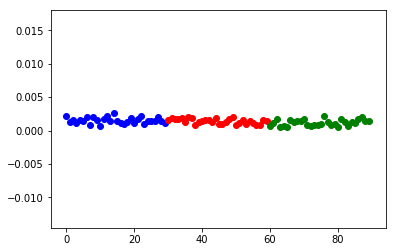

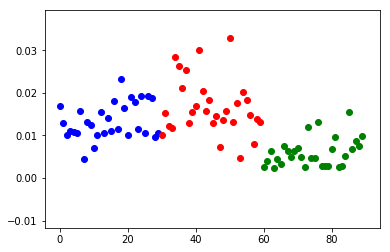

In [13]:
def visualize_features(k, all_feature_vectors):
    """
    plt.hist(all_feature_vectors[0:3, k], color='blue')
    plt.hist(all_feature_vectors[3:6, k], color='red')
    plt.hist(all_feature_vectors[6:9, k], color='green')
    """
    plt.scatter([i for i in range(30)], all_feature_vectors[0:30, k], color='blue')
    plt.scatter([i for i in range(30, 60)], all_feature_vectors[30:60, k], color='red')
    plt.scatter([i for i in range(60, 90)], all_feature_vectors[60:90, k], color='green')
    plt.show()
    

visualize_features(25, all_feature_vectors)    
visualize_features(3, all_feature_vectors)





#### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$


## Exercise 5.5 Retrieving the most similar and different images



Implement a function `retrieve_k_images_from_X(query, X, k)` where `query` is an image,  `X` ins the array containing the features from all the images and  `k` is an integer. The function should retrieve the `k` most similar and distant images (according to the l2 norm) and the distances from the closest and the furthest images to the query image. You can include the query image since it is in `X`.

- Make a plot with the first column beeing the query image and the other k columns the closest images in the feature space.

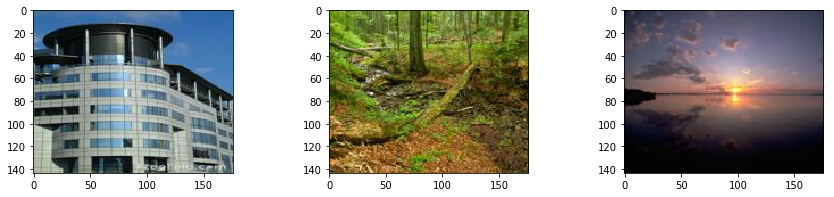

In [120]:
X_filter = np.array(all_feature_vectors)
ind_1 = 6
ind_2 = 30
ind_3 = 65

query_1 = X[6, :]
query_2 = X[30,:]
query_3 = X[65,:]


# Display the query images
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
ax[0].imshow(all_images[6]) 
ax[1].imshow(all_images[30])
ax[2].imshow(all_images[65])

In [122]:
X_filter.shape

(90, 48)

In [118]:
def retrieve_k_images_from_X_filter(query, X, k):
    query_vector = features_from_filter_bank(skimage.color.rgb2gray(query),
                                             filter_bank,
                                             filter_bank.shape[2])
    distances = []
    indices = []
    for i in range(X.shape[0]):
        distances.append(np.linalg.norm(query_vector - X[i]))
        indices.append(i)
    sorted_distances = sorted(distances)
    dist_to_return = []
    indices_to_return = []
    for i in range(k):
        indices_to_return.append(distances.index(sorted_distances[i]))
        dist_to_return.append(sorted_distances[i])
    return indices_to_return, dist_to_return

In [128]:
retrieve_k_images_from_X_filter(all_images[3], X_filter, 5)

([3, 1, 7, 27, 22],
 [0.0,
  0.02448736080140232,
  0.06034575788630375,
  0.060374379587084,
  0.06264013125533176])


## Exercise 5.6 Retrieving the most similar image based on the information about color

Based on exercises 5.3 and 5.4:
1)  Implement a function `get_rgb_Features(all_images)` that obtains the RGB information by applying `exposure.histogram(image,nbins=32)` to get a feature vector for each of the images in the union of the three datasets (forest, buildings, sunset). It must return a matrix containing at row $k$ feature vector for the input image $k$.

2)  Use the same function `retrieve_k_images_from_X(query, X, k)` where `query` is an image, `X` ins the array containing the features from all the images and  `k` is an integer. The function should retrieve the `k` most similar and distant images (according to the l2 norm) and the distances from the closest and the furthest images to the query image. You can include the query image since it is in `X`.

- And again, make a plot with the first column beeing the query image and the other k columns the closest images in the feature space.

In [85]:
def get_rgb_Features(all_images):
    n_images = len(all_images)
    all_feature_vectors = np.zeros((n_images*3,32))
    for i in range(n_images):
        all_feature_vectors[3*i] = exposure.histogram(all_images[i][:,:,0]/255,nbins=32)[0]
        all_feature_vectors[3*i + 1] = exposure.histogram(all_images[i][:,:,1]/255,nbins=32)[0]
        all_feature_vectors[3*i + 2] = exposure.histogram(all_images[i][:,:,2]/255,nbins=32)[0]

    return all_feature_vectors

In [126]:
X_rgb = get_rgb_Features(all_images)

In [127]:
X_rgb

array([[ 239.,  388.,  536., ...,  257.,  186.,  177.],
       [ 210.,  401.,  669., ...,  247.,  150.,  171.],
       [ 760.,  725., 1059., ...,  189.,  145.,  111.],
       ...,
       [3173., 1345.,  907., ...,  806.,  880.,  422.],
       [5591., 1299., 1015., ...,   57.,   16.,   10.],
       [6076., 1352., 1397., ...,   24.,   10.,    7.]])

In [116]:
def retrieve_k_images_from_X_rgb(query, X, k):
    query_vector = []
    query_vector.append(exposure.histogram(query[:,:,0]/255,nbins=32)[0])
    query_vector.append(exposure.histogram(query[:,:,1]/255,nbins=32)[0])
    query_vector.append(exposure.histogram(query[:,:,2]/255,nbins=32)[0])
    distances = []
    indices = []
    for i in range(int(X.shape[0]/3)):
        distances.append(np.linalg.norm(query_vector - X[3*i:3*i+3]))
        indices.append(i)
    sorted_distances = sorted(distances)
    dist_to_return = []
    indices_to_return = []
    for i in range(k):
        indices_to_return.append(distances.index(sorted_distances[i]))
        dist_to_return.append(sorted_distances[i])
    return indices_to_return, dist_to_return

In [129]:
retrieve_k_images_from_X_rgb(all_images[3], X_rgb, 5)

([3, 23, 27, 10, 14],
 [0.0,
  6003.4758265524815,
  7127.206605676589,
  7634.011265383357,
  7740.4317709027055])

## Exercise 5.7 Compute the accuracy of the algorithm: given a query image. 

Make a function 

```
accuracy(X, class_labels, k=5, query=x, class_query=y)
```

That takes as input a the dataset `X`, the `class_labels` for the images, the number of images to retrieve `k`, a query image `x` and the class of the query image `y`. Returns as output the number of retrieved images that belong to class `y` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: be careful to exclude the query image from the retrieved images.



- Compute the accuracy with k=4 with the previous images. Does the accuracy match the images retrieved from the previous exercise?



In [103]:
class_labels = np.concatenate((np.zeros(30), np.ones(30),  2*np.ones(30))).reshape(90,1)

In [132]:
def accuracy_filter(X, class_labels, k, query, class_query):
    indices, _ = retrieve_k_images_from_X_filter(query, X, k)
    counter = 0
    for i in range(k):
        if class_labels[indices[i]] == class_query:
            counter += 1
    acc = counter/k
    return acc

def accuracy_rgb(X, class_labels, k, query, class_query):
    indices, _ = retrieve_k_images_from_X_rgb(query, X, k)
    counter = 0
    for i in range(k):
        if class_labels[indices[i]] == class_query:
            counter += 1
    acc = counter/k
    return acc


In [136]:
print(accuracy_filter(X_filter, class_labels, 10, all_images[3], 0))
print(accuracy_rgb(X_rgb, class_labels, 10, all_images[3], 0))

0.9
0.6


- Compute the accuracy for both cases, when X is obtained by (A) applying the bank of filters or (B) the color information.



- Compare the results obtained. Which descriptors give better performance? Can you explain why?

## Exercise 5.8 Image retrieval based on texture and color. 

Make a function ` lm_features_rgb(image, filter_bank)`  that returns the features from the filter bank concatenated per color. If the previous feature vectors had 49 components now they will have 49*3 components. 


In [149]:
def lm_features_rgb(image, filter_bank):
    n_filters = filter_bank.shape[2]
    features_for_im = np.zeros(3*n_filters)
    features_for_im = np.concatenate([features_from_filter_bank(image[:,:,0], filter_bank, n_filters),
                                      features_from_filter_bank(image[:,:,1], filter_bank, n_filters),
                                      features_from_filter_bank(image[:,:,2], filter_bank, n_filters)])
        
    return features_for_im

In [151]:
lm_features = lm_features_rgb(all_images[3], filter_bank)

## Exercise 5.9 Apply the function to all the images in the dataset

Using ` lm_features_rgb(image, filter_bank)` build the features of all the datapoints in and save them in `X_lm_rgb`.
You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [153]:
!pip install joblib

    100% |████████████████████████████████| 276kB 1.1MB/s ta 0:00:01


In [244]:
from joblib import Parallel, delayed
def lm_features_rgb(all_images, filter_bank):
    # X_lm_rgb = np.zeros((3*len(all_images), len(filter_bank)))
    

In [252]:

return X_lm_rgb
X_lm_rgb = lm_features_rgb(all_images, filter_bank)

TypeError: 'numpy.uint8' object is not iterable

## 5.10 Compute the accuracy of the method using lm rgb features

Use the function implemented in 5.6 to compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

- Is the accuracy higher?

In [ ]:
# compute (X_lm_rgb) and cast it as array
X_lm_rgb = np.array(X_lm_rgb)